# Environment Setup in Colab

In [1]:
!pip install datasets transformers accelerate sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
dir_ = '/content/drive/MyDrive/Colab Notebooks/Doc_AI_Takehome/Takehome'
os.chdir(dir_)

# Download Data

In [8]:
from src.utils.download_data import download_ESConv_data

In [9]:
download_ESConv_data()

Size of JSON data: 1300 entries.
Data saved to ESConv.json


# Data Process Interface

```
processed_data = pipeline.process_data(
    [extract_supporter_strategy],  # Annotation functions
    get_supporter_responses,      # Processing function
    format_fn                     # Formatting function
)
```
* Annotation functions (annotate_fn_list): A list of callable functions that take raw data entries and return annotations. Each function should have the signature Callable[[dict], Tuple[str, dict]], where the first element in the tuple is an annotator identifier, and the second element is a dictionary of annotations.

* Processing function (process_fn): A single callable that processes the raw data. It should have the signature Callable[[dict], list], where it takes a single data entry and returns processed data as a list of strings.

* Formatting function (format_fn): A single callable that formats the processed data. It should have the signature Callable[[str, str, dict, list], dict], where it takes the annotator identifier, raw data entry, annotations, and processed text data, then returns a formatted data entry as a dictionary.

* Currently, the system does not have the capability to pair distinct annotator methods with their respective unique processing methods.
* Only support different annotator methods under the same process function to aviod ambiguity.

In [10]:
from src.data_processing.readers.json_reader import read_fn
from src.data_processing.label_annotator.heuristic_annotator import extract_supporter_strategy, extract_user_emotion, extract_conversation_situation, annotate_dialog
from src.data_processing.processors.classification_processor import get_supporter_responses, get_dialogue
from src.data_processing.formatters.json_formatter import format_fn
from src.data_processing.data_processing_pipeline import DataProcessingPipeline

In [12]:
# Test 1: Process for classification training (single annotator)
input_file_path = "./data/raw/ESConv.json"
pipeline = DataProcessingPipeline(lambda: read_fn(input_file_path))
test_1_data = pipeline.process_data([extract_supporter_strategy], get_supporter_responses, format_fn)

In [13]:
test_1_data.entries[0]['processed_data']

[{'annotator_id': 'heuristic_supporter_strategy',
  'feature': ['Hello, what would you like to talk about?',
   'What makes your job stressful for you?',
   'Do you help your clients to make it to a better financial situation?',
   'But you offer them a better future than what they have currently. It may not be what they wanted, but it helps them in the long run.',
   'I can understand that. ',
   'Is there another job that would pay you close to what you currently make?',
   "Is it possible to reframe how you look at your clients' dire financial situations?",
   "Some people can't do what you do because they don't have the heart to give someone else bad news. The reality is though, someone needs to fill that role and you do help people",
   "I've had to deal with collections before when I was in  bad financial condition. The person on the other line was really helpful though. She was understanding,",
   'It may not be for you. I think you should think about the pros and cons of keepin

In [14]:
# Test 2: Process for classification training (multiple annotators with same text processor)
input_file_path = "./data/raw/ESConv.json"
pipeline = DataProcessingPipeline(lambda: read_fn(input_file_path))
test_2_data = pipeline.process_data([extract_user_emotion, extract_conversation_situation], get_dialogue, format_fn)

In [15]:
test_2_data.entries[0]['processed_data']

[{'annotator_id': 'heuristic_user_emotion',
  'feature': "Hello  Hello, what would you like to talk about? I am having a lot of anxiety about quitting my current job. It is too stressful but pays well  What makes your job stressful for you? I have to deal with many people in hard financial situations and it is upsetting   Do you help your clients to make it to a better financial situation? I do, but often they are not going to get back to what they want. Many people are going to lose their home when safeguards are lifted   But you offer them a better future than what they have currently. It may not be what they wanted, but it helps them in the long run. That is true but sometimes I feel like I should put my feelings and health first   I can understand that.  Is there another job that would pay you close to what you currently make? Probably not. I was with the same company for a long time and I consistently get a bonus every year  Is it possible to reframe how you look at your clients' 

In [16]:
# Test 3: Process for Language Model training (no annotators)
input_file_path = "./data/raw/ESConv.json"
pipeline = DataProcessingPipeline(lambda: read_fn(input_file_path))
test_3_data = pipeline.process_data([annotate_dialog], get_dialogue, format_fn)

In [17]:
test_3_data.entries[0]['processed_data'][0]['feature']

"Hello  Hello, what would you like to talk about? I am having a lot of anxiety about quitting my current job. It is too stressful but pays well  What makes your job stressful for you? I have to deal with many people in hard financial situations and it is upsetting   Do you help your clients to make it to a better financial situation? I do, but often they are not going to get back to what they want. Many people are going to lose their home when safeguards are lifted   But you offer them a better future than what they have currently. It may not be what they wanted, but it helps them in the long run. That is true but sometimes I feel like I should put my feelings and health first   I can understand that.  Is there another job that would pay you close to what you currently make? Probably not. I was with the same company for a long time and I consistently get a bonus every year  Is it possible to reframe how you look at your clients' dire financial situations? I could try. It mostly gets to

# Model Inference

* Choose embedding models based on [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)
* Select [bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5) for the consideration of performance and efficiency.

## Model Embedding

In [18]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('BAAI/bge-small-en-v1.5',
                            cache_folder='./model')

In [19]:
from src.data_processing.data_processing_pipeline import DataProcessingPipeline
from src.model_training.data_loader import sample_data

In [20]:
input_file_path = "./data/raw/ESConv.json"
pipeline = DataProcessingPipeline(lambda: read_fn(input_file_path))
processed_data = pipeline.process_data([annotate_dialog], get_dialogue, format_fn)
docs = sample_data(processed_data.entries, sample_size=100)

## Find the Closest Pair

In [21]:
from src.model_inference.closest_pair_finder import find_closest_cosine_pair

In [22]:
find_closest_cosine_pair(docs, model)

(("I am worried after breaking up with my boyfriend that I will never find love again.    I'm sorry to hear about your breakup. Was it your boyfriend that ended the relationship and how long were you guys together?  We were together for 3 years and he ended it suddenly.  this actually happened to me last year. my girlfriend ended things completely out of the blue. it came to light that she felt this way for a while but didn't know how to speak to me about it. It's such a shocker and I'm dumbfounded and sad.  it is true that relationships can have a big impact on us especially when the end suddenly and seemingly without reason. this must be very stressful.  Yes, I wonder if I will ever love again.  it does take time to get over a breakup especially one that ends suddenly but I think once you get over the initial shockyou seem like a positive person so I believe you can get over this  Thanks.  What should I do next?  do you have any friends or family that you can talk to about your feeli

# Model Training

## Preprocessing

In [23]:
from src.data_processing.data_processing_pipeline import DataProcessingPipeline
from src.model_training.data_loader import split_data, tokenize
from datasets import DatasetDict
from torch.utils.data.dataloader import DataLoader
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [24]:
# Load raw data based on self-defined functions
input_file_path = "./data/raw/ESConv.json"
pipeline = DataProcessingPipeline(lambda: read_fn(input_file_path))
processed_data = pipeline.process_data([annotate_dialog], get_dialogue, format_fn)

In [25]:
# Transform raw data into Pytorch compatible format
ds_train, ds_valid = split_data(processed_data.entries, train_ratio=0.7, shuffle=True)
raw_datasets = DatasetDict({"train": ds_train, "valid": ds_valid})
tokenized_datasets = raw_datasets.map(
    tokenize,
    batched=True,
    fn_kwargs={'tokenizer': tokenizer}, # Pass tokenizer here
    remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
eval_dataloader = DataLoader(tokenized_datasets["valid"], batch_size=32)
dataloader = {'train': train_dataloader, 'val': eval_dataloader}

Map:   0%|          | 0/909 [00:00<?, ? examples/s]

Map:   0%|          | 0/391 [00:00<?, ? examples/s]

## Training Loop

In [26]:
from src.model_training.trainer import train_model

In [27]:
# Model
from transformers import AutoTokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Optimizer
from torch.optim import AdamW
def get_grouped_params(model, weight_decay=0.1, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]
optimizer = AdamW(get_grouped_params(model), lr=5e-4)

# Path
path = '/content/drive/MyDrive/Colab Notebooks/Doc_AI_Takehome/Takehome/model'

# Number of Epochs
num_epoch = 5

In [28]:
train_metric = train_model(model, dataloader, optimizer, path, num_epochs= num_epoch)

Epoch 1/5
----------


  0%|          | 0/70 [00:00<?, ?it/s]

Step 1, Loss: 3.729872703552246, LR: 5e-07
Step 2, Loss: 3.8260979652404785, LR: 1e-06
Step 3, Loss: 3.822129487991333, LR: 1.5e-06
Step 5, Loss: 3.8615386486053467, LR: 2.5e-06
Step 6, Loss: 3.8526294231414795, LR: 3e-06
Step 7, Loss: 3.7283036708831787, LR: 3.5e-06
Step 8, Loss: 3.83797025680542, LR: 4e-06
Step 10, Loss: 3.9266791343688965, LR: 5e-06
Step 11, Loss: 3.836754322052002, LR: 5.5e-06
Step 12, Loss: 3.6573779582977295, LR: 6e-06
Step 13, Loss: 3.7908778190612793, LR: 6.5e-06


Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Validation Loss: 3.579390525817871, Perplexity: 35.8516845703125
Epoch 2/5
----------


  0%|          | 0/70 [00:00<?, ?it/s]

Step 15, Loss: 3.646700620651245, LR: 7.5e-06
Step 16, Loss: 3.658233404159546, LR: 8e-06
Step 17, Loss: 3.773737668991089, LR: 8.500000000000002e-06
Step 19, Loss: 3.6990275382995605, LR: 9.5e-06
Step 20, Loss: 3.719248056411743, LR: 1e-05
Step 21, Loss: 3.608480215072632, LR: 1.0500000000000001e-05
Step 22, Loss: 3.6831791400909424, LR: 1.1e-05
Step 24, Loss: 3.5463900566101074, LR: 1.2e-05
Step 25, Loss: 3.524348735809326, LR: 1.25e-05
Step 26, Loss: 3.546117067337036, LR: 1.3e-05
Step 27, Loss: 3.4726450443267822, LR: 1.35e-05


Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Validation Loss: 3.447453498840332, Perplexity: 31.420278549194336
Epoch 3/5
----------


  0%|          | 0/70 [00:00<?, ?it/s]

Step 29, Loss: 3.573265552520752, LR: 1.4500000000000002e-05
Step 30, Loss: 3.583160400390625, LR: 1.5e-05
Step 31, Loss: 3.5390117168426514, LR: 1.55e-05
Step 33, Loss: 3.4901123046875, LR: 1.65e-05
Step 34, Loss: 3.4959897994995117, LR: 1.7000000000000003e-05
Step 35, Loss: 3.4194884300231934, LR: 1.7500000000000002e-05
Step 36, Loss: 3.487016439437866, LR: 1.8e-05
Step 38, Loss: 3.4078948497772217, LR: 1.9e-05
Step 39, Loss: 3.506868362426758, LR: 1.95e-05
Step 40, Loss: 3.3290305137634277, LR: 2e-05
Step 41, Loss: 3.472811222076416, LR: 2.05e-05


Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Validation Loss: 3.3669698238372803, Perplexity: 28.99054718017578
Epoch 4/5
----------


  0%|          | 0/70 [00:00<?, ?it/s]

Step 43, Loss: 3.475470781326294, LR: 2.1499999999999997e-05
Step 44, Loss: 3.4123313426971436, LR: 2.2e-05
Step 45, Loss: 3.4907281398773193, LR: 2.2499999999999998e-05
Step 47, Loss: 3.4683284759521484, LR: 2.3500000000000002e-05
Step 48, Loss: 3.4379632472991943, LR: 2.4e-05
Step 49, Loss: 3.4627199172973633, LR: 2.4500000000000003e-05
Step 50, Loss: 3.2264347076416016, LR: 2.5e-05
Step 52, Loss: 3.4375669956207275, LR: 2.6e-05
Step 53, Loss: 3.4178905487060547, LR: 2.65e-05
Step 54, Loss: 3.399179697036743, LR: 2.7e-05
Step 55, Loss: 3.4332175254821777, LR: 2.75e-05


Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Validation Loss: 3.317312240600586, Perplexity: 27.586105346679688
Epoch 5/5
----------


  0%|          | 0/70 [00:00<?, ?it/s]

Step 57, Loss: 3.4791150093078613, LR: 2.85e-05
Step 58, Loss: 3.4561474323272705, LR: 2.9000000000000004e-05
Step 59, Loss: 3.4523324966430664, LR: 2.95e-05
Step 61, Loss: 3.2581255435943604, LR: 3.05e-05
Step 62, Loss: 3.4254791736602783, LR: 3.1e-05
Step 63, Loss: 3.3931448459625244, LR: 3.15e-05
Step 64, Loss: 3.2429542541503906, LR: 3.2e-05
Step 66, Loss: 3.3473236560821533, LR: 3.3e-05
Step 67, Loss: 3.3455708026885986, LR: 3.35e-05
Step 68, Loss: 3.290990114212036, LR: 3.4000000000000007e-05
Step 69, Loss: 3.163447380065918, LR: 3.4500000000000005e-05


Validation:   0%|          | 0/52 [00:00<?, ?it/s]

Validation Loss: 3.2865490913391113, Perplexity: 26.750391006469727


## Training Progress

In [29]:
import matplotlib.pyplot as plt

def plot_training_progress(training_results):
    epoch_loss_train = training_results['epoch_loss_train']
    epoch_loss_val = training_results['epoch_loss_val']

    epochs = range(1, len(epoch_loss_train) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, epoch_loss_train, 'bo-', label='Training Loss')
    plt.plot(epochs, epoch_loss_val, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


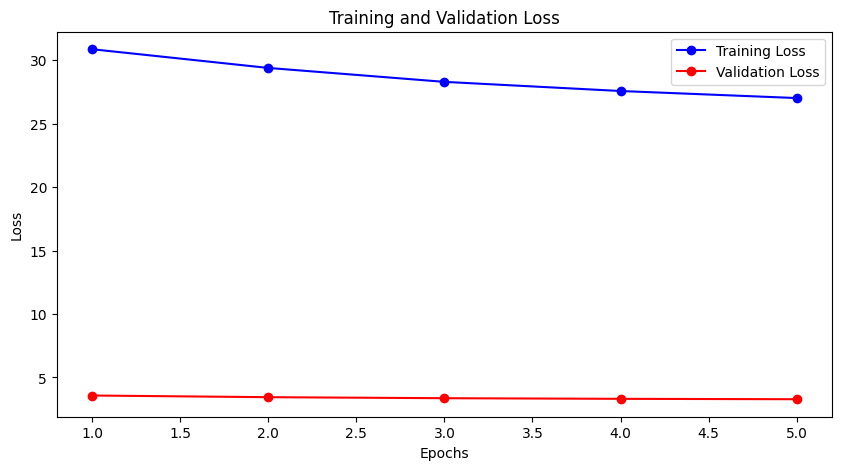

In [30]:
# Usage:
plot_training_progress(train_metric)

# Time Cost

     - Time cost for saving the whole dataset

     - Time cost for loading the whole dataset
     
     - Time cost for loading randomly selected 1k instances from the dataset.

In [16]:
from src.utils.download_data import download_ESConv_data
from src.utils.time_utils import time_function
from src.utils.data_loading import load_processed_data, load_random_sample
from src.data_processing.readers.json_reader import read_fn
from src.data_processing.data_processing_pipeline import DataProcessingPipeline
from src.data_processing.label_annotator.heuristic_annotator import extract_supporter_strategy
from src.data_processing.processors.classification_processor import get_supporter_responses
from src.data_processing.formatters.json_formatter import format_fn

In [8]:
# Time cost for saving the whole dataset
time_function(download_ESConv_data)

Size of JSON data: 1300 entries.
Data saved to ESConv.json
Function download_ESConv_data took 1.7089 seconds to execute.


In [18]:
# Time cost for loading the whole dataset
input_file_path = "./data/raw/ESConv.json"
output_file_path = "./data/formatted/ESConv_processed.json"
pipeline = DataProcessingPipeline(lambda: read_fn(input_file_path))
pipeline.process_data([extract_supporter_strategy], get_supporter_responses, format_fn)
pipeline.save(output_file_path)

output = time_function(load_processed_data, output_file_path)

Function load_processed_data took 0.1876 seconds to execute.


In [19]:
# Time cost for loading randomly selected 1k instances from the dataset.
output_file_path = "./data/formatted/ESConv_processed.json"
sample_size = 1000
output = time_function(load_random_sample, output_file_path, sample_size)

Function load_random_sample took 0.4062 seconds to execute.
